# Task 1.1 – ECG-dataset exploration
Read training-data (ECG-time series) from a .zip-file with a .bin-file inside

In [3]:
import struct
import zipfile
from typing import List
import pandas as pd

# reads a binary file containing a ragged array of shorts
def read_zip_binary(path: str) -> List[List[int]]:
    ragged_array = []
    with zipfile.ZipFile(path, 'r') as zf:
        inner_path = path.split("/")[-1].split(".")[0]
        with zf.open(f'{inner_path}.bin', 'r') as r:
            read_binary_from(ragged_array, r)
    return ragged_array

def read_binary_from(ragged_array, r):
    while True:
        size_bytes = r.read(4)
        if not size_bytes:
            break
        sub_array_size = struct.unpack('i', size_bytes)[0]
        sub_array = list(struct.unpack(f'{sub_array_size}h', r.read(sub_array_size * 2)))
        ragged_array.append(sub_array)

# list of labels
labels = pd.read_csv("../data/y_train.csv", header=None)[0].tolist()
# list of time series
train_data = read_zip_binary("../data/X_train.zip")

# Schritt 2: Erfolg prüfen
if isinstance(train_data, list) and len(train_data) > 0 and isinstance(train_data[0], list):
    print(f"Erfolgreich geladen: {len(train_data)} Zeitreihen")
    print(f"→ Erste Zeitreihe: {len(train_data[0])} Werte, Beispiel: {train_data[0][:10]}")
else:
    print("Fehler beim Einlesen der Binärdatei.")

Erfolgreich geladen: 6179 Zeitreihen
→ Erste Zeitreihe: 9000 Werte, Beispiel: [-217, -246, -294, -344, -363, -371, -377, -379, -373, -361]


Data Exploration

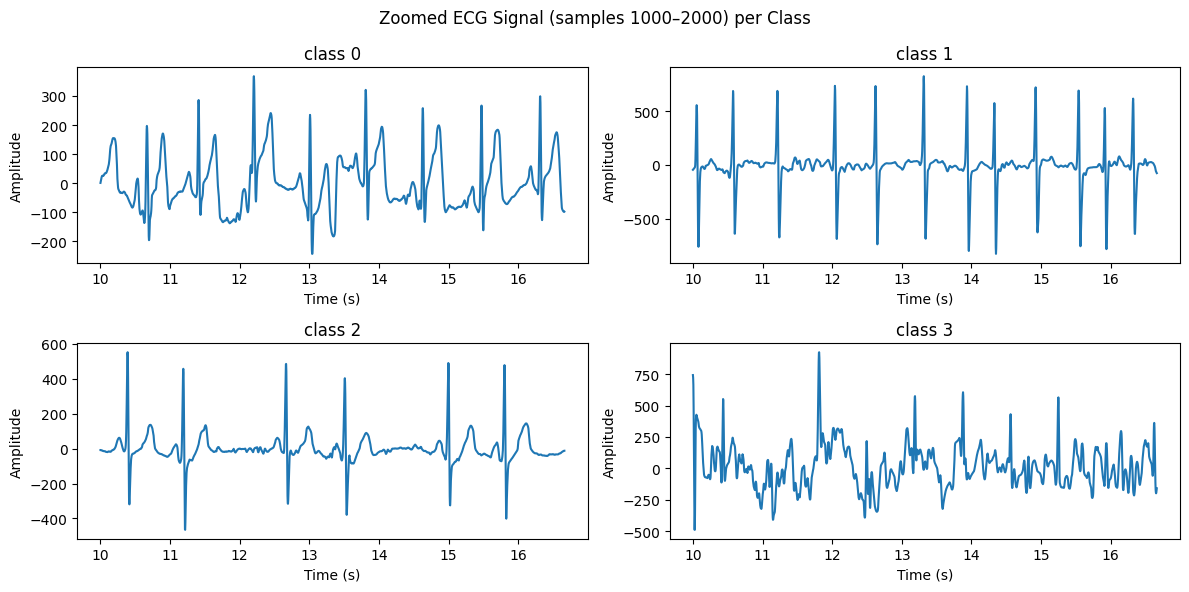

Class distribution: Counter({0: 3638, 2: 1765, 1: 549, 3: 227})


In [4]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def analyze_ecg_data(ecg_data: List[List[int]], labels: List[int]):
    lengths = [len(x) for x in ecg_data]
    df_stats = pd.DataFrame({
        "length": lengths,
        "label": labels
    })
    stats_summary = df_stats.groupby("label")["length"].describe()

    sampling_rate = 300  # Hz
    start_sample = 3000
    end_sample = 5000

    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    fig.suptitle("Zoomed ECG Signal (samples 1000–2000) per Class")
    for i in range(4):
        idx = df_stats[df_stats["label"] == i].index[0]
        example = ecg_data[idx]
        time_axis = np.arange(start_sample, end_sample) / sampling_rate
        axs[i // 2][i % 2].plot(time_axis, example[start_sample:end_sample])
        axs[i // 2][i % 2].set_title(f"class {i}")
        axs[i // 2][i % 2].set_xlabel("Time (s)")
        axs[i // 2][i % 2].set_ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    return stats_summary

# visualize the data
summary = analyze_ecg_data(train_data, labels)

# class distribution
class_distribution = Counter(labels)
print("Class distribution:", class_distribution)


validation split (80% for training / 20 % for validation)

In [5]:
from sklearn.model_selection import train_test_split
from collections import Counter
import pickle

#Input:
# train_data: Liste von ECG-Zeitreihen
# labels: Liste der zugehörigen Klassen (gleiche Länge)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    train_data,
    labels,
    test_size=0.2,            #  20% for validation
    stratify=labels,          # same distribution of classes in train and validation
    random_state=42           # for reproducibility
)
 
# Output:
# X_train_split: Trainingsdaten
# X_val_split: Validierungsdaten
# y_train_split: Labels für Trainingsdaten
# y_val_split: Labels für Validierungsdaten

# Speichern der Listen
with open("../data/split_data.pkl", "wb") as f:
    pickle.dump((X_train_split, X_val_split, y_train_split, y_val_split), f)

print(f"Trainingsdaten: {len(X_train_split)} Zeitreihen")
print(f"Validierungsmenge: {len(X_val_split)} Beispiele")

# class distribution
print("Train-class-distribution:", Counter(y_train_split))
print("Val-class-distribution:", Counter(y_val_split))




Trainingsdaten: 4943 Zeitreihen
Validierungsmenge: 1236 Beispiele
Train-class-distribution: Counter({0: 2910, 2: 1412, 1: 439, 3: 182})
Val-class-distribution: Counter({0: 728, 2: 353, 1: 110, 3: 45})
